# LightGBM Model Analysis

This notebook analyses the results of the Optuna training study used to train an "optimal" LightGBM model.

In [1]:
import warnings
warnings.filterwarnings("ignore")

import lightgbm as lgb
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.naive_bayes import GaussianNB
from sklearn.calibration import calibration_curve
from sklearn.metrics import *
import numpy as np
import seaborn as sns
sns.set()

## Training Baseline Model

Training a simple Gaussian Naive Bayes classifier to use as a baseline comparison.

In [2]:
train_data = np.genfromtxt('./train.csv', delimiter=',', skip_header=1)
val_data = np.genfromtxt('./val.csv', delimiter=',', skip_header=1)

gnb = GaussianNB()
gnb_y_pred = np.array([x[1] for x in gnb.fit(train_data[:,1:], train_data[:,:1].flatten()).predict_proba(val_data[:,1:])])
gnb_y_true = val_data[:,:1].flatten()

## Optuna Study Analysis

Study contains 250 trials (39 completed, 211 pruned)
Best trial: #3


number                                               3
value                                         0.457993
datetime_start              2020-06-06 23:26:24.465097
datetime_complete           2020-06-06 23:28:43.568503
duration                     0 days 00:02:19.103406000
params_bagging_fraction                       0.832966
params_bagging_freq                                  7
params_feature_fraction                       0.739225
params_lambda_l1                           0.000497316
params_lambda_l2                               1.55893
params_max_depth                                    62
params_min_child_samples                            93
params_num_leaves                                   49
state                                         COMPLETE
Name: 3, dtype: object

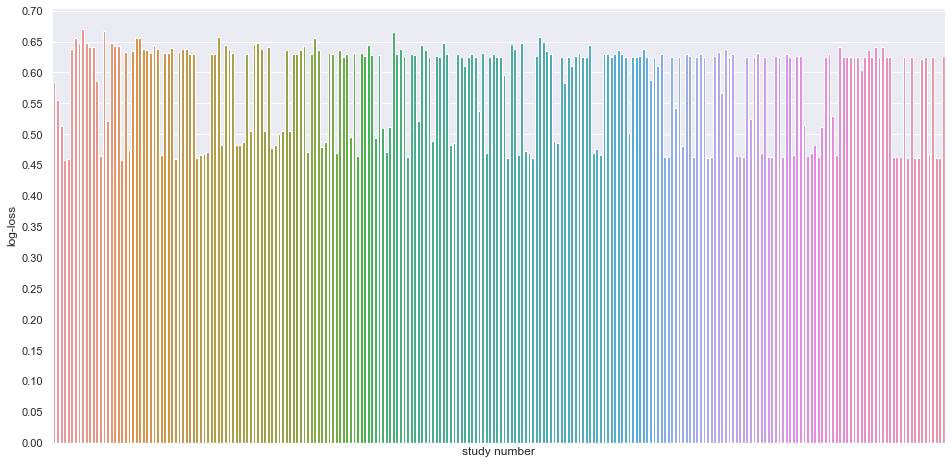

In [3]:
# load in Optuna results
study_df = pd.read_csv('./optuna_study.csv', index_col=0)
best_trial_id = study_df['value'].idxmin()
best_trial = study_df.iloc[best_trial_id]

print('Study contains {} trials ({} completed, {} pruned)'.format(
    len(study_df), 
    study_df['state'].value_counts()['COMPLETE'],
    study_df['state'].value_counts()['PRUNED']
))
print('Best trial: #{}'.format(best_trial_id))
display(best_trial)

plt.figure(figsize=(16,8))
g = sns.barplot(x=study_df['number'], y=study_df['value'])
g.yaxis.set_major_locator(ticker.MultipleLocator(0.05))
plt.gca().get_xaxis().set_ticks([])
plt.xlabel('study number')
plt.ylabel('log-loss')
plt.show()

### Parameter Impact

Analysing the effect of changing individual parameters on final auc.

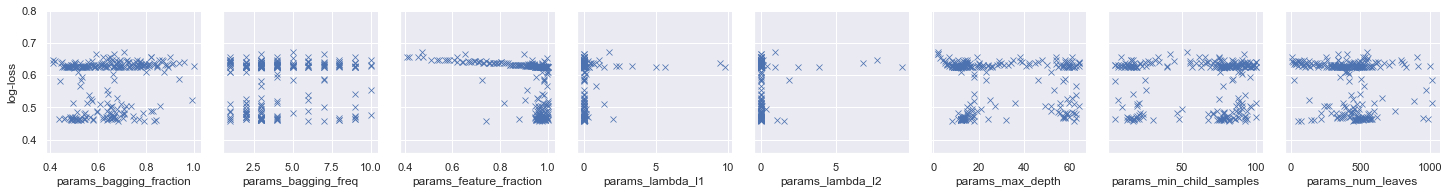

In [4]:
params = [col for col in study_df.columns if col.startswith('params_')]
g = sns.pairplot(
    data=study_df,
    y_vars=['value'], 
    x_vars=params,
    kind='scatter',
    markers='x'
)
g.set(ylabel='log-loss')
plt.ylim(study_df['value'].mean() - study_df['value'].std() * 3, study_df['value'].mean() + study_df['value'].std() * 3)
plt.show()

## Best Model Analysis

In [5]:
best_model_file = './models/LightGBM_model_003.txt'
with open(best_model_file, 'r', newline='\n') as f:
    best_model = lgb.Booster(model_str=f.read())

best_model_y_pred = best_model.predict(val_data[:,1:])
best_model_y_true = val_data[:,:1].flatten()

Finished loading model, total used 727 iterations


### Train/Val Learning Curve

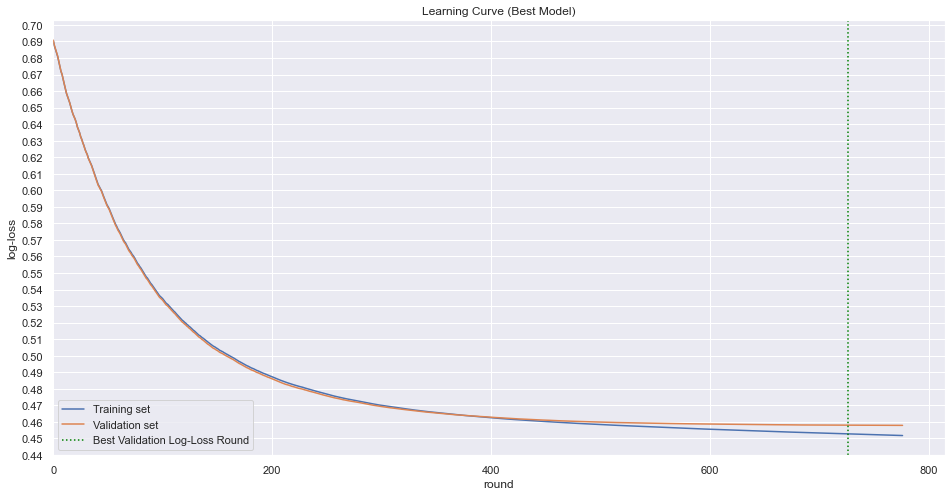

In [6]:
# load in trial csv
best_trial_id = study_df['value'].idxmin()
best_trial_df = pd.read_csv('./trials/trial_{:03d}.csv'.format(3))

plt.figure(figsize=(16,8))
best_round_result = best_trial_df.loc[best_trial_df['val_logloss'] == best_trial['value']]
g = sns.lineplot(x=best_trial_df['round'], y=best_trial_df['train_logloss'])
g = sns.lineplot(x=best_trial_df['round'], y=best_trial_df['val_logloss'])
g.xaxis.set_major_locator(ticker.MultipleLocator(200))
g.yaxis.set_major_locator(ticker.MultipleLocator(0.01))
g.set(xlabel='round', ylabel='log-loss')
plt.axvline(int(best_round_result['round']), 0, 1, c='green', linestyle=':')
plt.title('Learning Curve (Best Model)')
plt.xlim(-1,)
g.legend(labels=['Training set','Validation set', 'Best Validation Log-Loss Round'])
plt.show()

### Performance Summary

In [7]:
print('Classification report (baseline model, threshold = 0.5):\n')
print(classification_report(gnb_y_true, (gnb_y_pred >= 0.5), target_names=['CT round win', 'T round win']))

print('\n')

print('Classification report (best model, threshold = 0.5):\n')
print(classification_report(best_model_y_true, (best_model_y_pred >= 0.5), target_names=['CT round win', 'T round win']))

Classification report (baseline model, threshold = 0.5):

              precision    recall  f1-score   support

CT round win       0.68      0.85      0.76    189158
 T round win       0.79      0.57      0.66    179732

    accuracy                           0.72    368890
   macro avg       0.73      0.71      0.71    368890
weighted avg       0.73      0.72      0.71    368890



Classification report (best model, threshold = 0.5):

              precision    recall  f1-score   support

CT round win       0.75      0.79      0.77    189158
 T round win       0.77      0.73      0.75    179732

    accuracy                           0.76    368890
   macro avg       0.76      0.76      0.76    368890
weighted avg       0.76      0.76      0.76    368890



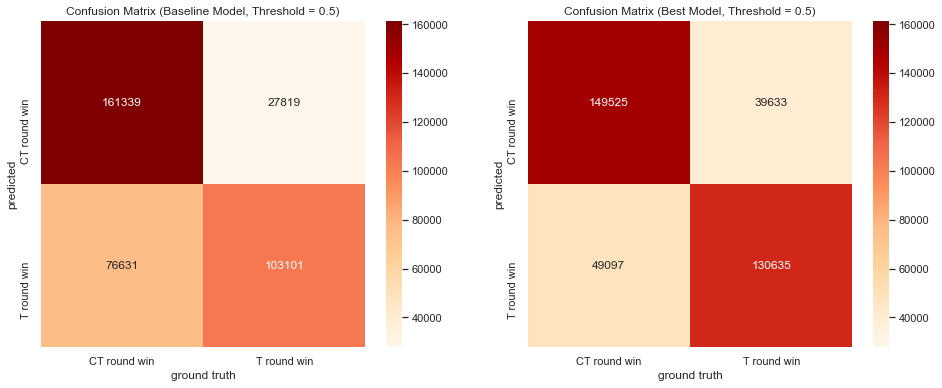

In [8]:
plt.figure(figsize = (16,6))

ax1 = plt.subplot(121)

cm1 = confusion_matrix(gnb_y_true, (gnb_y_pred >= 0.5))
cm2 = confusion_matrix(best_model_y_true, (best_model_y_pred >= 0.5))

min_val = min(np.min(cm1), np.min(cm2))
max_val = max(np.max(cm1), np.max(cm2))

cm_df = pd.DataFrame(cm1, index=['CT round win', 'T round win'], columns=['CT round win', 'T round win'])
plt.title('Confusion Matrix (Baseline Model, Threshold = 0.5)')
sns.heatmap(cm_df, annot=True, cmap='OrRd', fmt='g', vmin=min_val, vmax=max_val)
plt.xlabel('ground truth')
plt.ylabel('predicted')

ax2 = plt.subplot(122)

cm_df = pd.DataFrame(cm2, index=['CT round win', 'T round win'], columns=['CT round win', 'T round win'])
plt.title('Confusion Matrix (Best Model, Threshold = 0.5)')
sns.heatmap(cm_df, annot=True, cmap='OrRd', fmt='g', vmin=min_val, vmax=max_val)
plt.xlabel('ground truth')
plt.ylabel('predicted')

plt.show()

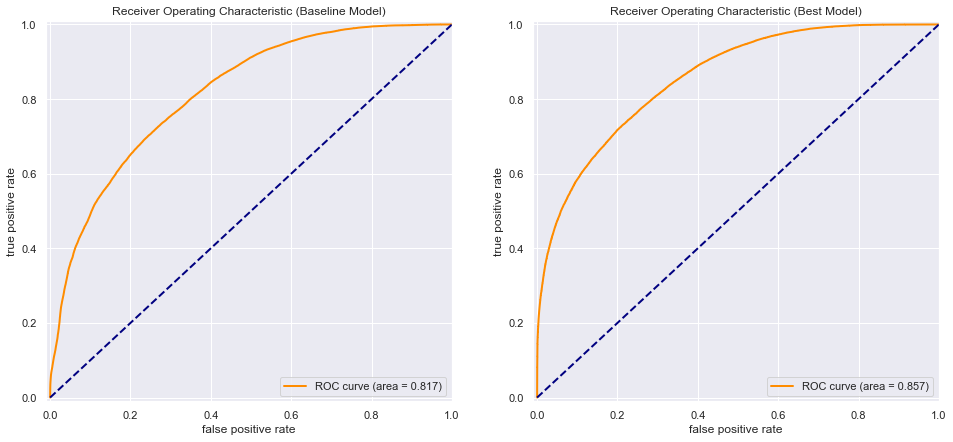

In [9]:
plt.figure(figsize = (16,7))

ax1 = plt.subplot(1,2,1)

fpr, tpr, _ = roc_curve(gnb_y_true, gnb_y_pred)
roc_auc = auc(fpr, tpr)
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([-0.01, 1.01])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('Receiver Operating Characteristic (Baseline Model)')
plt.legend(loc="lower right")

ax2 = plt.subplot(1,2,2)

fpr, tpr, _ = roc_curve(best_model_y_true, best_model_y_pred)
roc_auc = auc(fpr, tpr)
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([-0.01, 1.01])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('Receiver Operating Characteristic (Best Model)')
plt.legend(loc="lower right")

plt.show()

### Probability Calibration

Brier score (baseline model): 0.17820757886272426
Brier score (best model): 0.15371844178168825


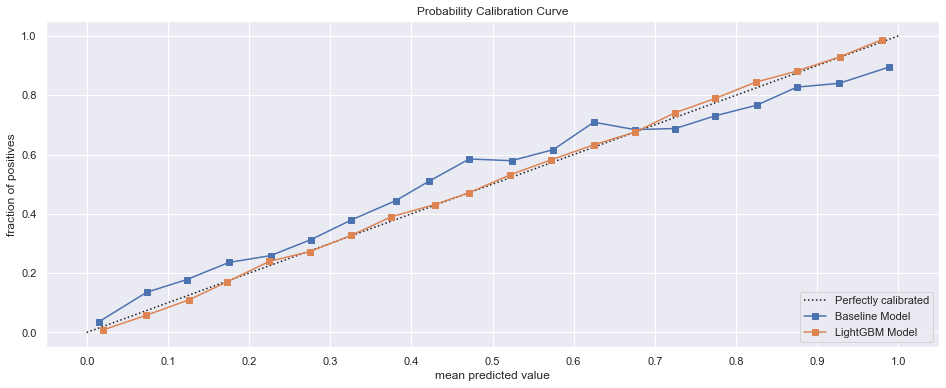

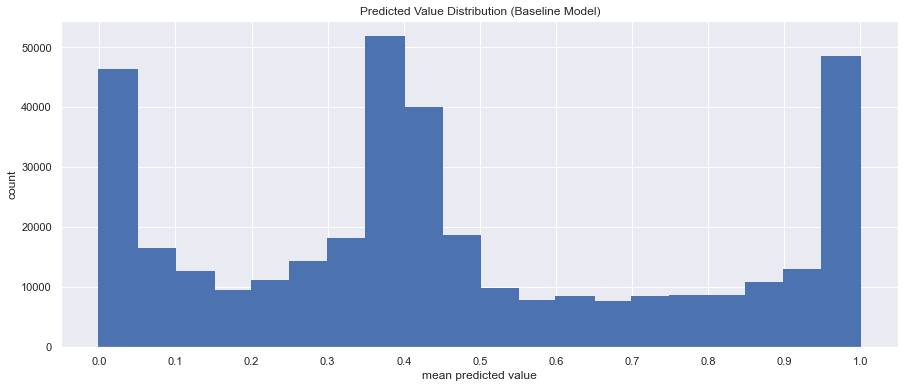

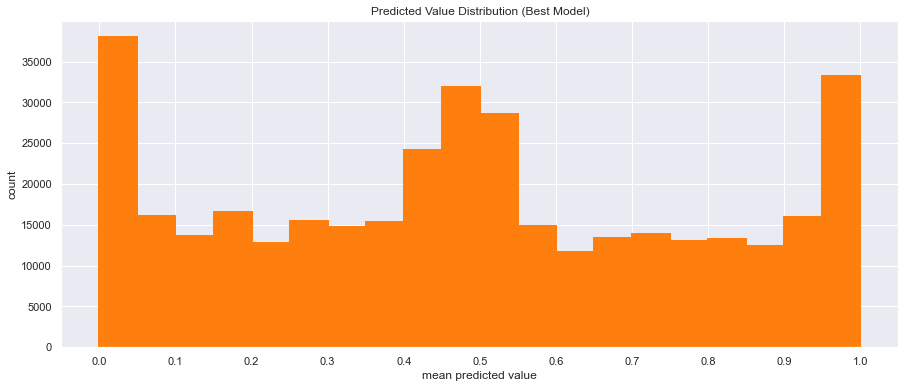

In [10]:
print('Brier score (baseline model):', brier_score_loss(gnb_y_true, gnb_y_pred))
print('Brier score (best model):', brier_score_loss(best_model_y_true, best_model_y_pred))

bins = 20

plt.figure(figsize=(16,6))
plt.plot([0,1], [0,1], 'k:', label='Perfectly calibrated')

fraction_of_positives, mean_predicted_value = calibration_curve(gnb_y_true, gnb_y_pred, n_bins=bins)
plt.plot(mean_predicted_value, fraction_of_positives, 's-', label='Baseline Model')

fraction_of_positives, mean_predicted_value = calibration_curve(best_model_y_true, best_model_y_pred, n_bins=bins)
plt.plot(mean_predicted_value, fraction_of_positives, 's-', label='LightGBM Model')

plt.legend(loc='lower right')
plt.title('Probability Calibration Curve')
plt.ylabel('fraction of positives')
plt.xlabel('mean predicted value')
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(0.1))
plt.show()

plt.figure(figsize=(15,6))
plt.hist(gnb_y_pred, range=(0, 1), bins=bins, histtype="step", lw=2, fill=True)
plt.title('Predicted Value Distribution (Baseline Model)')
plt.ylabel('count')
plt.xlabel('mean predicted value')
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(0.1))
plt.show()

plt.figure(figsize=(15,6))
plt.hist(best_model_y_pred, range=(0, 1), bins=bins, histtype="step", lw=2, fill=True, color='tab:orange')
plt.title('Predicted Value Distribution (Best Model)')
plt.ylabel('count')
plt.xlabel('mean predicted value')
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(0.1))
plt.show()

### Prediction Trends

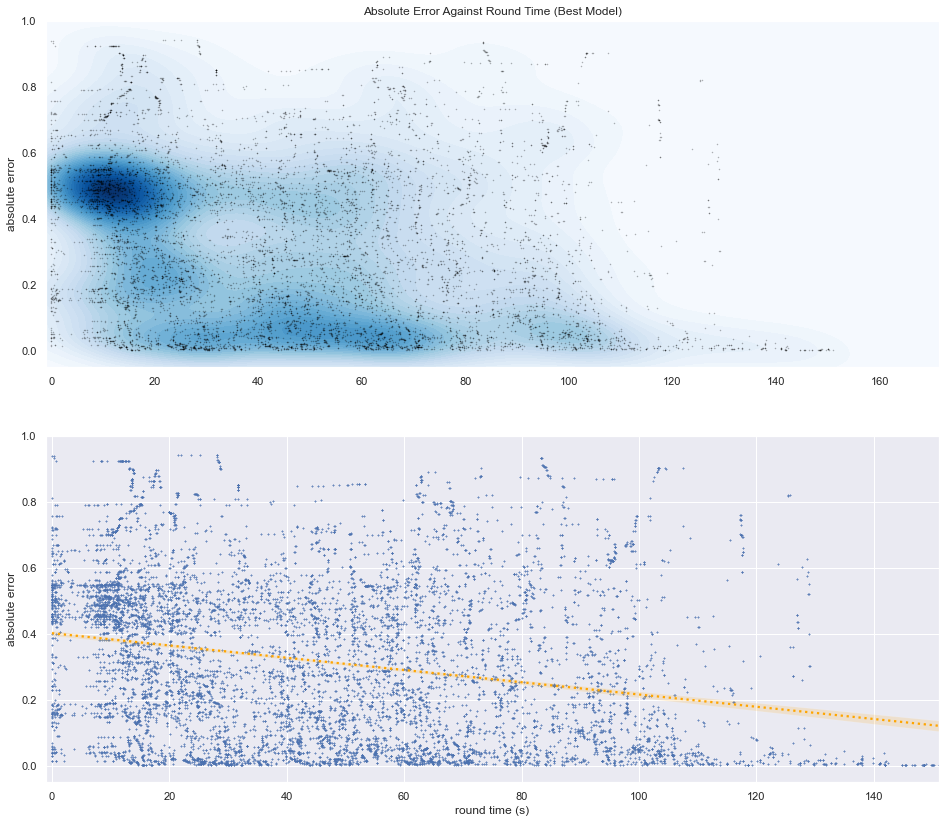

In [11]:
limit = 10000
x = val_data[:,7][:limit]
y = np.abs(best_model_y_pred[:limit]-val_data[:,0][:limit])

fig = plt.figure(figsize=(16, 14))
ax1 = plt.subplot2grid((2, 1), (0, 0))
ax2 = plt.subplot2grid((2, 1), (1, 0))

sns.kdeplot(data=x, data2=y, cmap='Blues', shade=True, shade_lowest=True, n_levels=40, ax=ax1)

ax1.scatter(x=x, y=y, marker='.', c='black', alpha=0.3, s=1)
sns.regplot(x=x, y=y, marker='x', line_kws={'color':'orange', 'linestyle':':'}, scatter_kws={'s': 1}, ax=ax2)

ax1.set_xlim(-1,)
ax2.set_xlim(-1,)
ax1.set_ylim(-0.05,1)
ax2.set_ylim(-0.05,1)
ax1.set_title('Absolute Error Against Round Time (Best Model)')
plt.xlabel('round time (s)')
ax1.set_ylabel('absolute error')
ax2.set_ylabel('absolute error')
plt.show()